In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./amazon_reviews_us_Toys_v1_00.tsv', sep='\t',
                 usecols=['customer_id','review_id','product_id',
                          'product_title','star_rating', 'helpful_votes',
                          'total_votes','vine','verified_purchase','review_date'])

In [3]:
df.shape

(4859927, 10)

In [4]:
df.head()

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date
0,18778586,RDIJS7QYB6XNR,B00EDBY7X8,Monopoly Junior Board Game,5.0,0.0,0.0,N,Y,2015-08-31
1,24769659,R36ED1U38IELG8,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,5.0,0.0,0.0,N,Y,2015-08-31
2,44331596,R1UE3RPRGCOLD,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,2.0,1.0,1.0,N,Y,2015-08-31
3,23310293,R298788GS6I901,B00ARPLCGY,Barbie Doll and Fashions Barbie Gift Set,5.0,0.0,0.0,N,Y,2015-08-31
4,38745832,RNX4EXOBBPN5,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,1.0,1.0,1.0,N,Y,2015-08-31


# Clean and prepare data 

## 1) Drop Non_verified purchases

In [5]:
# drop 841,721 non_verified purchases 

nonverified_purchase_indexes = df[df.verified_purchase=='N'].index
df.drop(nonverified_purchase_indexes, inplace=True)

In [6]:
df.shape

(4018206, 10)

## 2) Drop Non_valid review_date & convert it to *datetime* type

In [7]:
# get valid & non-valid review_date
import re

def get_date(date):
    if re.search('([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))', date):
        return date
    return None

In [8]:
df.review_date = df.review_date.astype(str).apply(get_date)

In [9]:
df.review_date.isnull().sum()

273

In [10]:
# 273 non-dated review_date
df.dropna(inplace=True)

In [11]:
# Convert type of 'review_date' from object to datetime 
df.review_date = pd.to_datetime(df['review_date'], format='%Y-%m-%d')

In [12]:
df.shape

(4017891, 10)

## 3) Add 'category' column based on product_title 

In [13]:
# Define categories
all_toy_categories=['Arts,Crafts-Art,Craft,Adhesive,Apron,Smock,Clay,Dough,Craft,Painting,Drawing,Easel,Fuse,Perler,Bead,Pipe,Printing,Stamping,Scissor,Sticker',
                    'Baby,Toddler-Baby,Toddler,Activity,Center,Bath,Car,Seat,Stroller,Push,Pull,Rattle,Horse,Teether',
                    'Building-Building,Gear,Marble,Stacking,Blocks',
                    'Collectible-Collectible,Collectibles,Display,Statue,Bobblehead,Bust',
                    'Dolls-Doll,Dollhouse,Dollhouses,Dolls',
                    'Dress,Pretend-Dress,Beauty,Fashion,Costume,Hat,Mask,Pretend,Wigs',
                    'Games-Arcade,Table,Board,Card,Cards,Dice,Floor,Game,Gaming,Tile,Games',
                    'Hobbies-Hobbies,Coin,Collecting,Hobby,Tools,Hardware,Models,Model,Pinewood,Rocket,Stamp',
                    'Electronics-Electronics,Gadget,Dance,Mat,DVD,Electronic,Handheld,Karaoke,MP3,Video,Player,Plug,Remote,Controlled,Robot,Walkie,Talkies,Channel,Radio,Infrared,Drone,2.4GHz,Batteries',
                    'Furniture,Décor,Storage-Backpack,Lunch,Box,Bedding,Slumber,Furniture,Room,Décor,Decor,Chest,Storage,Table,Bag',
                    'Learning,Education-Education,Counting,Math,Learning,Geographic,Globe,Habitat,Musical,Instrument,Optic,Reading,Writing,Rock,Tumbler,Science,Solar,Power,Kits,Book',
                    'Novelty,Gag-Fidget,Spinner,Fortune,Telling,Gag,Practical,Joke,Juggling,Magic,Magnets,Magnetic,Miniatures,Money,Banks,Novelty,Nesting,Spinning,Prism,Kaleidoscope,Slime,Putty,Spy,Viewfinder,Yo yo',
                    'Party Supplies-Balloon,Banner,Birthday,Candle,Cake,Cupcake,Toppers,Centerpiece,Noisemaker,Party,Favor,Pack,Tableware,Piñata,Pinata,Tablecover,Foam,Bubbles',
                    'Play Vehicles-Die Cast,Vehicles,Train,Railway,Vehicle,Car,Race,Tracks',
                    'Puppets,Puppet Theaters-Finger,Puppets,Hand,Marionette,Puppet,Theater,Ventriloquist',
                    'Puzzles-3D,Brain,Teaser,Jigsaw,Pegged,Puzzle,Sudoku,Puzzles',
                    'Sports,Outdoor-Bike,Ball,Pit,Footbag,Water Blaster,Fitness,Flying,Gardening,Inflatable,Bouncer,Kickball,Playground,Ball,Kite,Wind,Nature,Outdoor,Tent,Playhouse,Pogo,Hopper,Pool,Sand,Sandboxe,Sport,Trampoline',
                    'Stuffed,Animals,Plush-Plush,Interactive,Animal,Stuffed,Animals,Teddy,Teddy Bear',
                    'Figures,Playsets-Action,Figure,Playset',
                    'Tricycles,Scooters,Wagons-Tricycle,Scooters,Scooter,Wagon,Wagons,Unicycle']

In [14]:
# Special words that should be excluded from the search logic
excluded_keywords = [
'&',
'and',
'by',
'-',
'the'
]

# This function returns already clean category in one step
# Function that returns category given a product_title
def get_category(keywords):
    global all_toy_categories
    if isinstance(keywords, list):
        for keyword in keywords:
            if not keyword.lower() in excluded_keywords:
                for category in all_toy_categories:
                    if keyword.lower() in category.lower():
                        return category.strip().split('-')[0] # cut off redundant stuff right here
    return 'Others'

In [15]:
# Split only product_title into an array
df['split_title'] = df['product_title'].str.split()

In [16]:
df['category'] = df['split_title'].apply(get_category)

In [17]:
df.head(100)

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,split_title,category
0,18778586,RDIJS7QYB6XNR,B00EDBY7X8,Monopoly Junior Board Game,5.0,0.0,0.0,N,Y,2015-08-31,"[Monopoly, Junior, Board, Game]",Games
1,24769659,R36ED1U38IELG8,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,5.0,0.0,0.0,N,Y,2015-08-31,"[56, Pieces, of, Wooden, Train, Track, Compati...",Play Vehicles
2,44331596,R1UE3RPRGCOLD,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,2.0,1.0,1.0,N,Y,2015-08-31,"[Super, Jumbo, Playing, Cards, by, S&S, Worldw...",Games
3,23310293,R298788GS6I901,B00ARPLCGY,Barbie Doll and Fashions Barbie Gift Set,5.0,0.0,0.0,N,Y,2015-08-31,"[Barbie, Doll, and, Fashions, Barbie, Gift, Set]",Dolls
4,38745832,RNX4EXOBBPN5,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,1.0,1.0,1.0,N,Y,2015-08-31,"[Emazing, Lights, eLite, Flow, Glow, Sticks, -...","Novelty,Gag"
5,13394189,R3BPETL222LMIM,B009B7F6CA,Melissa & Doug Water Wow Coloring Book - Vehicles,5.0,0.0,0.0,N,Y,2015-08-31,"[Melissa, &, Doug, Water, Wow, Coloring, Book,...","Arts,Crafts"
6,2749569,R3SORMPJZO3F2J,B0101EHRSM,Big Bang Cosmic Pegasus (Pegasis) Metal 4D Hig...,3.0,2.0,2.0,N,Y,2015-08-31,"[Big, Bang, Cosmic, Pegasus, (Pegasis), Metal,...",Party Supplies
7,41137196,R2RDOJQ0WBZCF6,B00407S11Y,Fun Express Insect Finger Puppets 12ct Toy,5.0,0.0,0.0,N,Y,2015-08-31,"[Fun, Express, Insect, Finger, Puppets, 12ct, ...","Puppets,Puppet Theaters"
8,433677,R2B8VBEPB4YEZ7,B00FGPU7U2,Fisher-Price Octonauts Shellington's On-The-Go...,5.0,0.0,0.0,N,Y,2015-08-31,"[Fisher-Price, Octonauts, Shellington's, On-Th...",Others
9,1297934,R1CB783I7B0U52,B0013OY0S0,Claw Climber Goliath/ Disney's Gargoyles,1.0,0.0,1.0,N,Y,2015-08-31,"[Claw, Climber, Goliath/, Disney's, Gargoyles]",Others


## 4) Add 'investment' column based on categories 

In [18]:
# Define investment list  
investment = [{'Type': 'Arts,Crafts',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Baby,Toddler',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Building',  'Large': 0, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Collectible',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Dolls',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Dress,Pretend',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Games',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Hobbies',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':1}, 
              {'Type': 'Electronics',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':1}, 
              {'Type': 'Furniture,Décor,Storage',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Learning,Education',  'Large': 1, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':0}, 
              {'Type': 'Novelty,Gag',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':0}, 
              {'Type': 'Party Supplies',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Play Vehicles',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':1}, 
              {'Type': 'Puppets,Puppet Theaters',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Puzzles',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Sports,Outdoor',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Stuffed,Animals,Plush',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Figures,Playsets',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Tricycles,Scooters,Wagons',  'Large': 0, 'Over_1kg': 1, 'Mechanism': 1, 'Electronics':0}, 
              {'Type': 'Others',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 1, 'Electronics':0}, 
             ]

In [19]:
# Create df of invesments 
df_investment = pd.DataFrame(investment, columns =['Type', 'Large', 'Over_1kg', 'Mechanism', 'Electronics'])
df_investment['Summary'] = df_investment.sum(axis=1)
df_investment.loc[df_investment['Summary'] == 0, 'associated_expenses'] = 'low'
df_investment.loc[df_investment['Summary'] > 0, 'associated_expenses'] = 'medium'
df_investment.loc[df_investment['Summary'] > 1, 'associated_expenses'] = 'high'

df_investment

,Type,Large,Over_1kg,Mechanism,Electronics,Summary,associated_expenses
0,"Arts,Crafts",0,0,0,0,0,low
1,"Baby,Toddler",1,1,0,0,2,high
2,Building,0,1,0,0,1,medium
3,Collectible,1,1,0,0,2,high
4,Dolls,0,0,0,0,0,low
5,"Dress,Pretend",0,0,0,0,0,low
6,Games,0,0,0,0,0,low
7,Hobbies,0,0,1,1,2,high
8,Electronics,0,0,0,1,1,medium
9,"Furniture,Décor,Storage",1,1,0,0,2,high


In [20]:
df_investment.set_index('Type')

,Large,Over_1kg,Mechanism,Electronics,Summary,associated_expenses
Type,,,,,,
"Arts,Crafts",0,0,0,0,0,low
"Baby,Toddler",1,1,0,0,2,high
Building,0,1,0,0,1,medium
Collectible,1,1,0,0,2,high
Dolls,0,0,0,0,0,low
"Dress,Pretend",0,0,0,0,0,low
Games,0,0,0,0,0,low
Hobbies,0,0,1,1,2,high
Electronics,0,0,0,1,1,medium


In [68]:
# Create a Series of 'Type' and 'associated_expenses'
investmentSeries = pd.Series(data= list(df_investment.associated_expenses), index=df_investment.Type)
len(list(investmentSeries.index))

21

In [22]:
# Function to get investment type
def get_investment_kind(category):
    if category in investmentSeries.index:
        return investmentSeries[category]
    return 'not_as_investment'

In [23]:
# Add 'investment' column
if 'investment' in df.columns:
    df.drop(columns=['investment'])
df['investment'] = df.category.apply(get_investment_kind)    

In [24]:
df.head(100)

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,split_title,category,investment
0,18778586,RDIJS7QYB6XNR,B00EDBY7X8,Monopoly Junior Board Game,5.0,0.0,0.0,N,Y,2015-08-31,"[Monopoly, Junior, Board, Game]",Games,low
1,24769659,R36ED1U38IELG8,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,5.0,0.0,0.0,N,Y,2015-08-31,"[56, Pieces, of, Wooden, Train, Track, Compati...",Play Vehicles,high
2,44331596,R1UE3RPRGCOLD,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,2.0,1.0,1.0,N,Y,2015-08-31,"[Super, Jumbo, Playing, Cards, by, S&S, Worldw...",Games,low
3,23310293,R298788GS6I901,B00ARPLCGY,Barbie Doll and Fashions Barbie Gift Set,5.0,0.0,0.0,N,Y,2015-08-31,"[Barbie, Doll, and, Fashions, Barbie, Gift, Set]",Dolls,low
4,38745832,RNX4EXOBBPN5,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,1.0,1.0,1.0,N,Y,2015-08-31,"[Emazing, Lights, eLite, Flow, Glow, Sticks, -...","Novelty,Gag",medium
5,13394189,R3BPETL222LMIM,B009B7F6CA,Melissa & Doug Water Wow Coloring Book - Vehicles,5.0,0.0,0.0,N,Y,2015-08-31,"[Melissa, &, Doug, Water, Wow, Coloring, Book,...","Arts,Crafts",low
6,2749569,R3SORMPJZO3F2J,B0101EHRSM,Big Bang Cosmic Pegasus (Pegasis) Metal 4D Hig...,3.0,2.0,2.0,N,Y,2015-08-31,"[Big, Bang, Cosmic, Pegasus, (Pegasis), Metal,...",Party Supplies,low
7,41137196,R2RDOJQ0WBZCF6,B00407S11Y,Fun Express Insect Finger Puppets 12ct Toy,5.0,0.0,0.0,N,Y,2015-08-31,"[Fun, Express, Insect, Finger, Puppets, 12ct, ...","Puppets,Puppet Theaters",low
8,433677,R2B8VBEPB4YEZ7,B00FGPU7U2,Fisher-Price Octonauts Shellington's On-The-Go...,5.0,0.0,0.0,N,Y,2015-08-31,"[Fisher-Price, Octonauts, Shellington's, On-Th...",Others,high
9,1297934,R1CB783I7B0U52,B0013OY0S0,Claw Climber Goliath/ Disney's Gargoyles,1.0,0.0,1.0,N,Y,2015-08-31,"[Claw, Climber, Goliath/, Disney's, Gargoyles]",Others,high


In [25]:
# Check if there is any not_as_investment entries 
df[df.investment=='not_as_investment'].loc[:, ['category','investment']].groupby('category').size().sum()

0

In [26]:
# categoies' size BEFORE droping Others category's entries 
df.groupby('category').size().sort_values(ascending=False)

category
Others                       892529
Arts,Crafts                  331803
Electronics                  275980
Figures,Playsets             253664
Games                        248443
Novelty,Gag                  213201
Party Supplies               208359
Baby,Toddler                 206806
Learning,Education           205699
Stuffed,Animals,Plush        168907
Sports,Outdoor               168196
Dress,Pretend                140123
Furniture,Décor,Storage      137667
Dolls                        120778
Hobbies                      106439
Collectible                   79302
Play Vehicles                 74690
Puzzles                       66445
Building                      59834
Puppets,Puppet Theaters       50924
Tricycles,Scooters,Wagons      8102
dtype: int64

## 5) Drop 'Others' category

In [27]:
others_indexes = df[df.category=='Others'].index
df.drop(others_indexes, inplace=True)

In [28]:
df.shape

(3125362, 13)

### Categories' size based on number of reviews

In [29]:
# categoies' size AFTER droping ... Others category's entries 
df.groupby('category').size().sort_values(ascending=False)

category
Arts,Crafts                  331803
Electronics                  275980
Figures,Playsets             253664
Games                        248443
Novelty,Gag                  213201
Party Supplies               208359
Baby,Toddler                 206806
Learning,Education           205699
Stuffed,Animals,Plush        168907
Sports,Outdoor               168196
Dress,Pretend                140123
Furniture,Décor,Storage      137667
Dolls                        120778
Hobbies                      106439
Collectible                   79302
Play Vehicles                 74690
Puzzles                       66445
Building                      59834
Puppets,Puppet Theaters       50924
Tricycles,Scooters,Wagons      8102
dtype: int64

## So far...

- Droping the non-verfied purchase's rows 
- Droping non-valid review_date's rows
- Adding *'category'* columns and labeling products with their close categories based on their product_titles
- Adding *'investment'* columns and labeling products with their investment levels based on their categories
- Droping 'Others' category and related rows 

# 1) What are main competitors for top branded toys? How about non_popular branded toys??

---
# Analyze Top Branded Toys 

## 1) Create a list of top branded toys from 1998 to 2015

In [30]:
# Top 25 toys brand based on Brandirectory.com (Brand Finance Directory) web site for year 2015
# https://brandirectory.com/rankings/toys-25-2015

brandFinance_25top = ['lego','fisher-price', 'barbie', 'mattel', 'nerf', 'playskool', 'hasbro',
                      'mobile suit gundam', 'power rangers', 'monopoly', 'monster high', 'bandai namco',
                      'hot wheels', 'mega bloks', 'play-doh', 'ben 10', 'my little pony', 'star wars',
                      'transformers', 'masked rider', 'bandai', 'magic: the gathering', 'magic the gathering',
                      'littlest pet shop', 'leapforg', 'matchbox']

In [31]:
# Top 18 toys barnd from 1998 to 2015 based on Insider.com and Pocket-lint.com
# https://www.insider.com/popular-christmas-toys-2016-12#2010-ipad-26
# https://www.pocket-lint.com/parenting/news/142866-the-most-popular-christmas-toys-and-tech-from-over-the-last-40-years

insider_pocketLint_18top = ['furby', 'pokemon', 'razor scooter', 'brazt doll', 'brazt', 'beyblades', 'robosapien',
               'xbox 360', 'playstation 3', 'nintendo ds', 'nintendo wii', 'nook', 'zhu zhu pet', 
               'leapPad explorer', 'wii u', 'big hugs elmo', 'let\'s rock elmo', 'elsa doll']

In [32]:
# 22 featured berand based on Amazon.com 
amazon_featured_brands = ['baby alive','barbie','beyblade','disney','fisher-price','funko',
                          'gund','hatchimals','hot wheels','kidkraft','learning resources',
                          'lego','little tikes','l.o.l surprise' , 'melissa & doug','nerf',
                          'osmo','play-doh','playmobil','playskool','radio flyer' ,'ravensburger']

In [33]:
# Concatinate all lists together --> top_brands list 
top_brands = list(set().union(brandFinance_25top,insider_pocketLint_18top, amazon_featured_brands))
len(top_brands)

59

## 2) Labeled products with their brand

### 2-1) Create a new column as 'brand' and labeled products based on *top_brands* list 

In [34]:
# Function to check a product belonges to top brand groups or not (ntb = not_top_branded)

def get_brand(product,brand_list, brand_name):
    for brand in brand_list:
        if brand in product.lower():
            brand_name = brand
            break
    return brand_name        

In [ ]:
## ????????????????????
def drop_col(data_frame, col):
    if col in data_frame.columns: 
        data_frame.drop(columns=[col], inplace=True)
    return data_frame    

In [35]:
# Create a new column on dataframe named 'brand'

if 'brand' in df.columns: 
    df.drop(columns=['brand'])
    
df['brand'] = df.product_title.astype(str).apply(get_brand,args=[top_brands,'ntb']) # ntb = non_top_branded 

In [36]:
df.head()

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,split_title,category,investment,brand
0,18778586,RDIJS7QYB6XNR,B00EDBY7X8,Monopoly Junior Board Game,5.0,0.0,0.0,N,Y,2015-08-31,"[Monopoly, Junior, Board, Game]",Games,low,monopoly
1,24769659,R36ED1U38IELG8,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,5.0,0.0,0.0,N,Y,2015-08-31,"[56, Pieces, of, Wooden, Train, Track, Compati...",Play Vehicles,high,ntb
2,44331596,R1UE3RPRGCOLD,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,2.0,1.0,1.0,N,Y,2015-08-31,"[Super, Jumbo, Playing, Cards, by, S&S, Worldw...",Games,low,ntb
3,23310293,R298788GS6I901,B00ARPLCGY,Barbie Doll and Fashions Barbie Gift Set,5.0,0.0,0.0,N,Y,2015-08-31,"[Barbie, Doll, and, Fashions, Barbie, Gift, Set]",Dolls,low,barbie
4,38745832,RNX4EXOBBPN5,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,1.0,1.0,1.0,N,Y,2015-08-31,"[Emazing, Lights, eLite, Flow, Glow, Sticks, -...","Novelty,Gag",medium,ntb


### 2-2) Find most frequent brands based on number of reviews in the dataset --> final_top_brands

In [37]:
df.groupby(['brand']).size().sort_values(ascending=False)

brand
ntb                     2350626
disney                   138811
melissa & doug           102716
fisher-price              60476
lego                      58979
barbie                    40051
star wars                 29315
pokemon                   27486
monster high              25516
transformers              20808
funko                     20792
little tikes              18926
learning resources        18738
nerf                      17650
hot wheels                16953
bandai                    16539
gund                      16349
my little pony            14709
kidkraft                  13100
radio flyer               12431
ravensburger              11709
magic the gathering        7729
mattel                     7461
mega bloks                 7163
magic: the gathering       7157
playskool                  6812
hasbro                     6713
power rangers              5742
littlest pet shop          5259
beyblade                   5253
monopoly                   4971
pl

***Note:*** Based on the above result, we do Not consider brands with ***less that 500 reviews***, and dismiss them as top brands.

In [38]:
# Find less frequesnt top brands on Amazon dataset

brands_sizeSeries = df.groupby('brand').size()
indexes = brands_sizeSeries.index
values = brands_sizeSeries.values

less_frequent_brands = []
for index, value in zip(indexes, values):
    if value < 500: 
        less_frequent_brands.append(index)

In [39]:
# 10 less frequent brands based on database reviews 
less_frequent_brands 

['big hugs elmo',
 "let's rock elmo",
 'masked rider',
 'nintendo ds',
 'nintendo wii',
 'playstation 3',
 'razor scooter',
 'robosapien',
 'wii u']

In [40]:
final_top_brands = [item for item in top_brands if item not in less_frequent_brands]
len(final_top_brands)

50

### Edit 'brand' columns based on *final_top_brands* list

In [42]:
if 'brand' in df.columns: 
    df.drop(columns=['brand'])
    
df['brand'] = df.product_title.astype(str).apply(get_brand,args=[final_top_brands,'ntb']) # ntb = non_top_branded

In [43]:
df.groupby(['brand']).size().sort_values(ascending=False)

brand
ntb                     2351670
disney                   138811
melissa & doug           102716
fisher-price              60476
lego                      58979
barbie                    40051
star wars                 29315
pokemon                   27486
monster high              25516
transformers              20808
funko                     20792
little tikes              18926
learning resources        18738
nerf                      17650
hot wheels                16953
bandai                    16539
gund                      16349
my little pony            14709
kidkraft                  13100
radio flyer               12431
ravensburger              11709
magic the gathering        7729
mattel                     7461
mega bloks                 7163
magic: the gathering       7157
playskool                  7150
hasbro                     6713
power rangers              5742
littlest pet shop          5259
beyblade                   5253
monopoly                   4971
pl

In [44]:
# number of all branded products 
df[df.brand!='ntb'].shape

(773692, 14)

### Create a sub-df for top-branded toys 

In [45]:
top_branded_df = df[df.brand!='ntb']

In [46]:
top_branded_df.shape

(773692, 14)

In [47]:
top_branded_df.groupby(['brand']).size().sort_values(ascending=False)

brand
disney                  138811
melissa & doug          102716
fisher-price             60476
lego                     58979
barbie                   40051
star wars                29315
pokemon                  27486
monster high             25516
transformers             20808
funko                    20792
little tikes             18926
learning resources       18738
nerf                     17650
hot wheels               16953
bandai                   16539
gund                     16349
my little pony           14709
kidkraft                 13100
radio flyer              12431
ravensburger             11709
magic the gathering       7729
mattel                    7461
mega bloks                7163
magic: the gathering      7157
playskool                 7150
hasbro                    6713
power rangers             5742
littlest pet shop         5259
beyblade                  5253
monopoly                  4971
playmobil                 4962
furby                     3906
pl

### 2-3) Plot top 10 most frequent top-branded toys based on brand names and number of reviews

In [48]:
top_10brands = top_branded_df.groupby(['brand']).size().sort_values(ascending=False)[:10]
top_10brands

brand
disney            138811
melissa & doug    102716
fisher-price       60476
lego               58979
barbie             40051
star wars          29315
pokemon            27486
monster high       25516
transformers       20808
funko              20792
dtype: int64

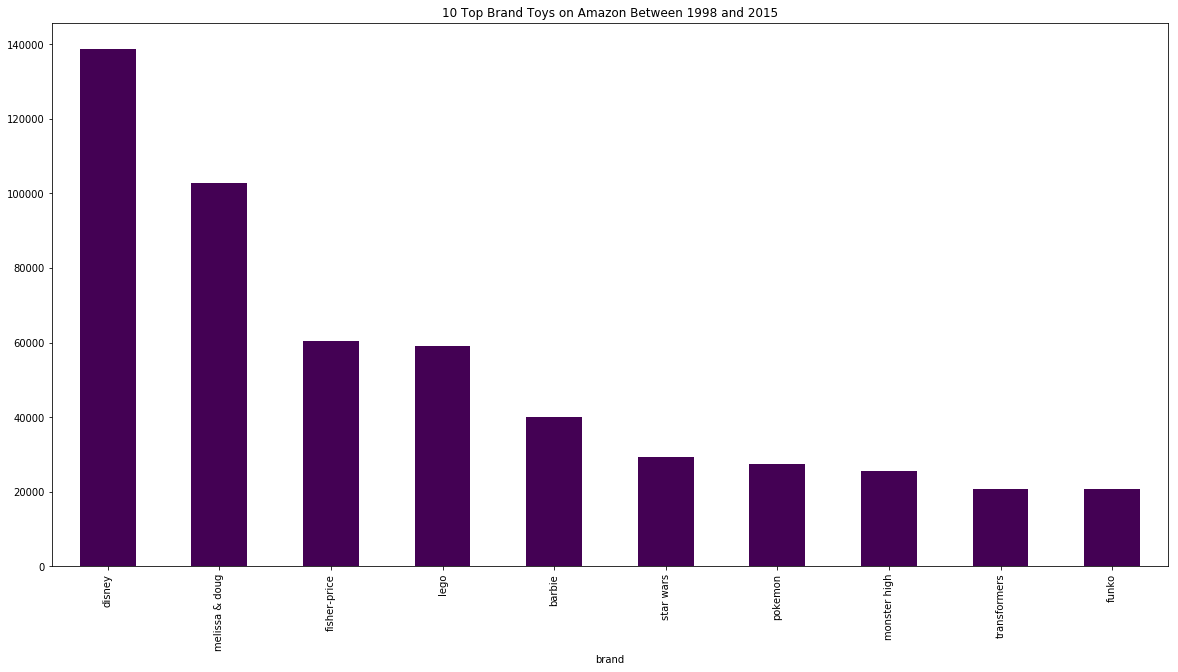

In [49]:
top_10brands.plot(kind='bar', figsize=(20,10),title='10 Top Brand Toys on Amazon Between 1998 and 2015',
                         colormap='viridis')

---
# Analyze Top Non-popular branded Toys 

In [50]:
df[df.brand=='ntb'].shape

(2351670, 14)

In [51]:
# Non-popular branded toys based on their product_titles and number of their reviews

df[df.brand=='ntb'].groupby('product_title').size().sort_values(ascending=False)

product_title
Cards Against Humanity                                                                                                                                                                                23124
Cards Against Humanity: First Expansion                                                                                                                                                                5851
VTech Sit-to-Stand Learning Walker                                                                                                                                                                     4374
Cards Against Humanity: Second Expansion                                                                                                                                                               3838
The Original Stomp Rocket                                                                                                                                                 

## 1) Create non-popular brand list based on above result

In [52]:
# 10 High most frequent non-popular branded toys 

nonpopular_10brands = ['cards against humanity', 'syma', 'vtech', 'snap circuits', 'stomp rocket',
                     'spot it!', 'udi','accoutrements horse head mask', 'rainbow loom', 'ticket to ride']
len(nonpopular_10brands)

10

## 2) Create a sub_df for nonpopular brands 

In [53]:
nonpopular_df = df[df.brand=='ntb']

In [54]:
nonpopular_df.shape

(2351670, 14)

In [55]:
nonpopular_df.head()

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,split_title,category,investment,brand
1,24769659,R36ED1U38IELG8,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,5.0,0.0,0.0,N,Y,2015-08-31,"[56, Pieces, of, Wooden, Train, Track, Compati...",Play Vehicles,high,ntb
2,44331596,R1UE3RPRGCOLD,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,2.0,1.0,1.0,N,Y,2015-08-31,"[Super, Jumbo, Playing, Cards, by, S&S, Worldw...",Games,low,ntb
4,38745832,RNX4EXOBBPN5,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,1.0,1.0,1.0,N,Y,2015-08-31,"[Emazing, Lights, eLite, Flow, Glow, Sticks, -...","Novelty,Gag",medium,ntb
6,2749569,R3SORMPJZO3F2J,B0101EHRSM,Big Bang Cosmic Pegasus (Pegasis) Metal 4D Hig...,3.0,2.0,2.0,N,Y,2015-08-31,"[Big, Bang, Cosmic, Pegasus, (Pegasis), Metal,...",Party Supplies,low,ntb
7,41137196,R2RDOJQ0WBZCF6,B00407S11Y,Fun Express Insect Finger Puppets 12ct Toy,5.0,0.0,0.0,N,Y,2015-08-31,"[Fun, Express, Insect, Finger, Puppets, 12ct, ...","Puppets,Puppet Theaters",low,ntb


## 3) Re-label nonpopular-df entries' brand column based on *nonpopular_brands* list 

In [56]:
if 'brand' in nonpopular_df: 
    nonpopular_df.drop(columns=['brand'])
    
nonpopular_df['brand'] = nonpopular_df.product_title.astype(str).apply(get_brand,args=[nonpopular_10brands,'ntb'])

/Users/MonA/anaconda3/envs/Statistics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [57]:
nonpopular_df.head(100)

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,split_title,category,investment,brand
1,24769659,R36ED1U38IELG8,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,5.0,0.0,0.0,N,Y,2015-08-31,"[56, Pieces, of, Wooden, Train, Track, Compati...",Play Vehicles,high,ntb
2,44331596,R1UE3RPRGCOLD,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,2.0,1.0,1.0,N,Y,2015-08-31,"[Super, Jumbo, Playing, Cards, by, S&S, Worldw...",Games,low,ntb
4,38745832,RNX4EXOBBPN5,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,1.0,1.0,1.0,N,Y,2015-08-31,"[Emazing, Lights, eLite, Flow, Glow, Sticks, -...","Novelty,Gag",medium,ntb
6,2749569,R3SORMPJZO3F2J,B0101EHRSM,Big Bang Cosmic Pegasus (Pegasis) Metal 4D Hig...,3.0,2.0,2.0,N,Y,2015-08-31,"[Big, Bang, Cosmic, Pegasus, (Pegasis), Metal,...",Party Supplies,low,ntb
7,41137196,R2RDOJQ0WBZCF6,B00407S11Y,Fun Express Insect Finger Puppets 12ct Toy,5.0,0.0,0.0,N,Y,2015-08-31,"[Fun, Express, Insect, Finger, Puppets, 12ct, ...","Puppets,Puppet Theaters",low,ntb
10,52006292,R2D90RQQ3V8LH,B00519PJTW,100 Foot Multicolor Pennant Banner,5.0,0.0,0.0,N,Y,2015-08-31,"[100, Foot, Multicolor, Pennant, Banner]","Sports,Outdoor",high,ntb
11,32071052,R1Y4ZOUGFMJ327,B001TCY2DO,Pig Jumbo Foil Balloon,5.0,0.0,0.0,N,Y,2015-08-31,"[Pig, Jumbo, Foil, Balloon]",Party Supplies,low,ntb
12,7360347,R2BUV9QJI2A00X,B00DOQCWF8,Minecraft Animal Toy (6-Pack),5.0,0.0,1.0,N,Y,2015-08-31,"[Minecraft, Animal, Toy, (6-Pack)]","Stuffed,Animals,Plush",low,ntb
14,13545982,R1T96CG98BBA15,B00NWGEKBY,Team Losi 8IGHT-E RTR AVC Electric 4WD Buggy V...,3.0,2.0,4.0,N,Y,2015-08-31,"[Team, Losi, 8IGHT-E, RTR, AVC, Electric, 4WD,...",Play Vehicles,high,ntb
17,18461411,R2SDXLTLF92O0H,B00VPXX92W,Teenage Mutant Ninja Turtles T-Machines Tiger ...,5.0,0.0,0.0,N,Y,2015-08-31,"[Teenage, Mutant, Ninja, Turtles, T-Machines, ...","Arts,Crafts",low,ntb


In [58]:
nonpopular_df.groupby('brand').size().sort_values(ascending=False)

brand
ntb                              2227442
cards against humanity             39809
vtech                              29101
syma                               21543
udi                                16317
rainbow loom                        5143
ticket to ride                      3793
stomp rocket                        3750
snap circuits                       2290
accoutrements horse head mask       2151
spot it!                             331
dtype: int64

In [59]:
frequent_10nonpopular_brandSeries = nonpopular_df[nonpopular_df.brand!='ntb'].groupby('brand').size().sort_values(ascending=False)
frequent_10nonpopular_brandSeries

brand
cards against humanity           39809
vtech                            29101
syma                             21543
udi                              16317
rainbow loom                      5143
ticket to ride                    3793
stomp rocket                      3750
snap circuits                     2290
accoutrements horse head mask     2151
spot it!                           331
dtype: int64

### 3) Plot top 10 most frequent nonpopular-branded toys based on brand names and number of reviews


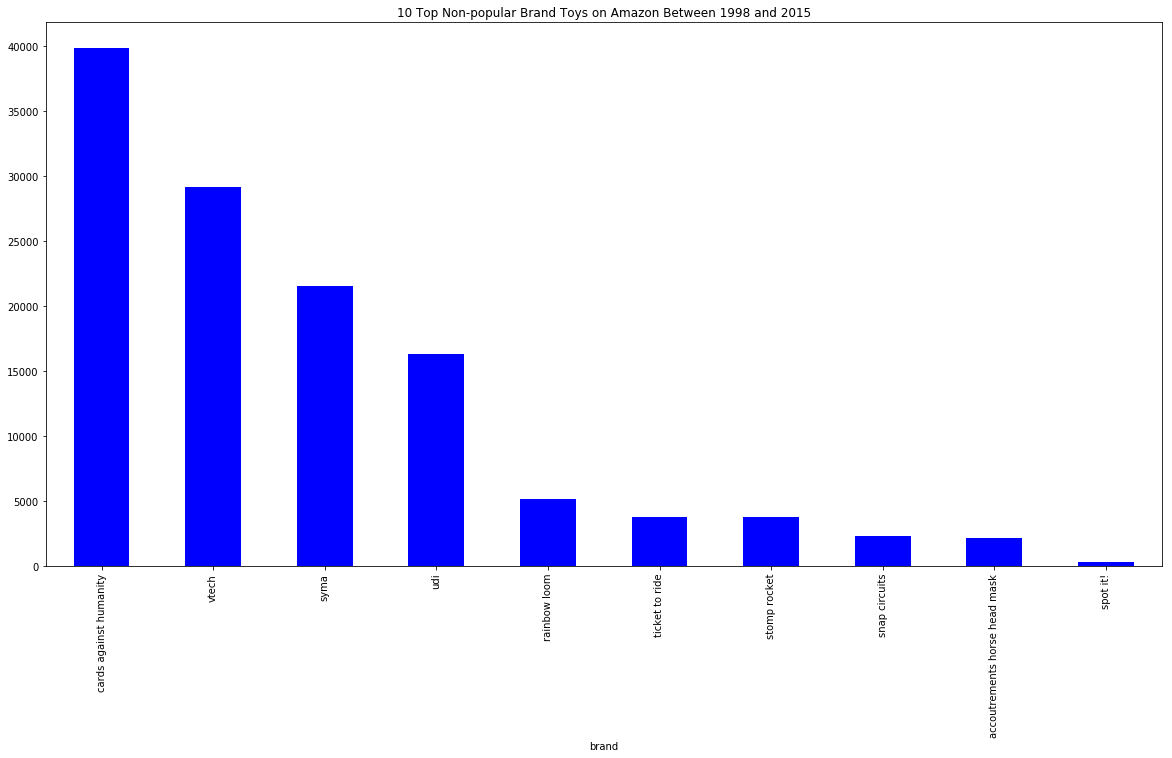

In [60]:
frequent_10nonpopular_brandSeries.plot(kind='bar', figsize=(20,10),title='10 Top Non-popular Brand Toys on Amazon Between 1998 and 2015',
                         colormap='brg')

# Analyze market share based on product categories for 10 top-branded and 10 nonpopular-branded Toys 

### Groupby whole dataset based on categories & brand names --> 🤔🤔🤔


In [61]:
df.groupby(['category','brand']).size().sort_values(ascending=False)

category                   brand              
Electronics                ntb                    223334
Games                      ntb                    218211
Arts,Crafts                ntb                    193880
Novelty,Gag                ntb                    186544
Party Supplies             ntb                    171030
Baby,Toddler               ntb                    165374
Figures,Playsets           ntb                    163485
Learning,Education         ntb                    137720
Sports,Outdoor             ntb                    135825
Stuffed,Animals,Plush      ntb                    130987
Dress,Pretend              ntb                    113782
Arts,Crafts                melissa & doug         102058
Furniture,Décor,Storage    ntb                     98666
Hobbies                    ntb                     89670
Dolls                      ntb                     65957
Collectible                ntb                     64440
Puzzles                    ntb           

## 1) Group top branded toys based on categories

In [63]:
top_branded_df.groupby('category').size().sort_values(ascending=False)

category
Arts,Crafts                  137923
Figures,Playsets              90179
Learning,Education            67979
Dolls                         54821
Electronics                   52646
Baby,Toddler                  41432
Furniture,Décor,Storage       39001
Stuffed,Animals,Plush         37920
Party Supplies                37329
Sports,Outdoor                32371
Games                         30232
Novelty,Gag                   26657
Dress,Pretend                 26341
Play Vehicles                 25441
Building                      22429
Hobbies                       16769
Collectible                   14862
Puppets,Puppet Theaters        9572
Puzzles                        7551
Tricycles,Scooters,Wagons      2237
dtype: int64

In [104]:
# High rating top branded toys

top_branded_df[top_branded_df.star_rating>=4].groupby('category').size().sort_values(ascending=False)

category
Arts,Crafts                  118375
Figures,Playsets              76265
Learning,Education            56920
Dolls                         48664
Electronics                   42847
Baby,Toddler                  35140
Stuffed,Animals,Plush         32757
Furniture,Décor,Storage       32368
Party Supplies                30574
Sports,Outdoor                26608
Games                         24908
Play Vehicles                 21884
Novelty,Gag                   21724
Building                      20475
Dress,Pretend                 20137
Hobbies                       14491
Collectible                   12403
Puppets,Puppet Theaters        8045
Puzzles                        6316
Tricycles,Scooters,Wagons      1868
dtype: int64

## 2) Group non-popular branded toys based on categories

In [64]:
nonpopular_df.groupby('category').size().sort_values(ascending=False)

category
Electronics                  223334
Games                        218211
Arts,Crafts                  193880
Novelty,Gag                  186544
Party Supplies               171030
Baby,Toddler                 165374
Figures,Playsets             163485
Learning,Education           137720
Sports,Outdoor               135825
Stuffed,Animals,Plush        130987
Dress,Pretend                113782
Furniture,Décor,Storage       98666
Hobbies                       89670
Dolls                         65957
Collectible                   64440
Puzzles                       58894
Play Vehicles                 49249
Puppets,Puppet Theaters       41352
Building                      37405
Tricycles,Scooters,Wagons      5865
dtype: int64

In [105]:
# High rating nonpopular toys
nonpopular_df[nonpopular_df.star_rating>=4].groupby('category').size().sort_values(ascending=False)

category
Games                        180473
Electronics                  168748
Arts,Crafts                  152495
Novelty,Gag                  139029
Baby,Toddler                 136269
Figures,Playsets             134459
Party Supplies               127829
Stuffed,Animals,Plush        112197
Learning,Education           107939
Sports,Outdoor               101106
Dress,Pretend                 84088
Furniture,Décor,Storage       77956
Hobbies                       70872
Dolls                         56850
Collectible                   51759
Puzzles                       47094
Play Vehicles                 39688
Puppets,Puppet Theaters       33777
Building                      29982
Tricycles,Scooters,Wagons      4801
dtype: int64

## 3) Plot market share

In [132]:
labels = list(top_branded_df.groupby('category').size().index)
branded_toys = top_branded_df[top_branded_df.star_rating>=4].groupby('category').size().values
nonpopulare_toys = nonpopular_df[nonpopular_df.star_rating>=4].groupby('category').size().values

In [136]:
len(branded_toys)

20

In [137]:
len(nonpopulare_toys)

20

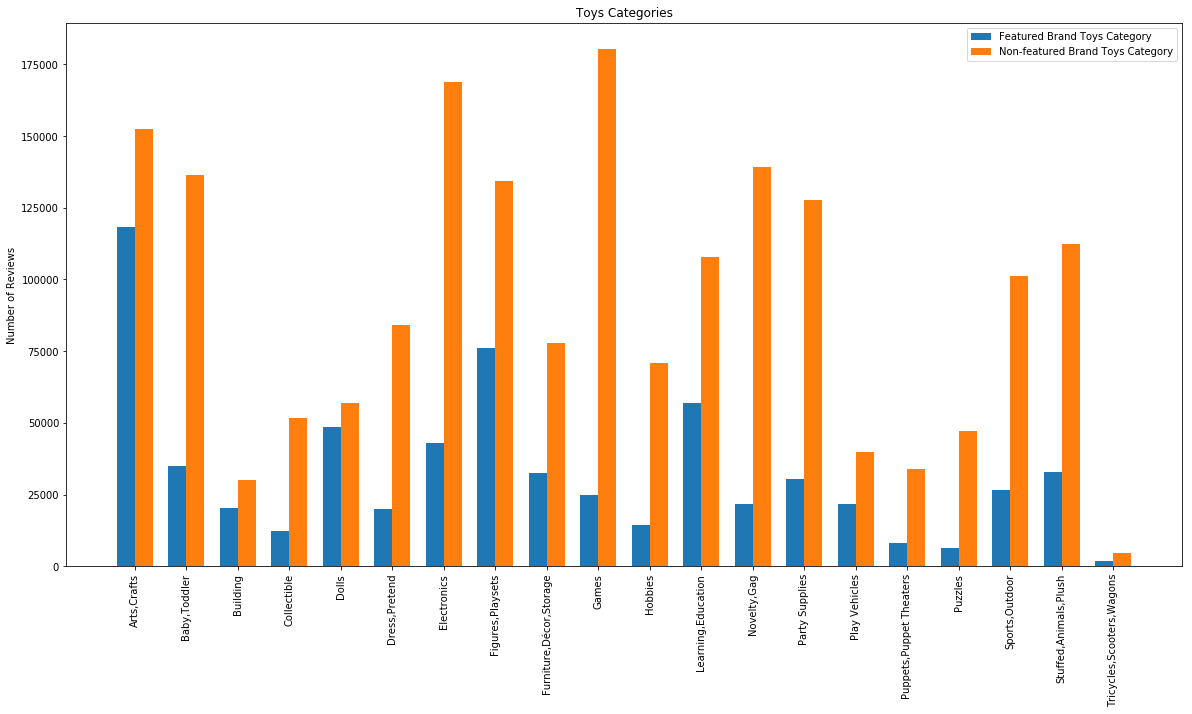

In [139]:
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, branded_toys, width, label='Featured Brand Toys Category')
rects2 = ax.bar(x + width/2, nonpopulare_toys, width, label='Non-featured Brand Toys Category')

ax.set_ylabel('Number of Reviews')
ax.set_title('Toys Categories')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

plt.show()

# 2) How did customers' preferences change over time for low-investment toys / medium-investment toys / high-investment toys?

In [119]:
import datetime 
start = pd.datetime(1997,1,5)
end = pd.datetime(2018,8,31)

In [114]:
# Select the last business quarter of each year

timerange = pd.date_range(start, end, freq='BM')
timerange

DatetimeIndex(['1997-01-31', '1997-02-28', '1997-03-31', '1997-04-30',
               '1997-05-30', '1997-06-30', '1997-07-31', '1997-08-29',
               '1997-09-30', '1997-10-31',
               ...
               '2017-11-30', '2017-12-29', '2018-01-31', '2018-02-28',
               '2018-03-30', '2018-04-30', '2018-05-31', '2018-06-29',
               '2018-07-31', '2018-08-31'],
              dtype='datetime64[ns]', length=260, freq='BM')

In [120]:
df['year'] = df.review_date.dt.year

In [124]:
df.year.isnull().sum()

0

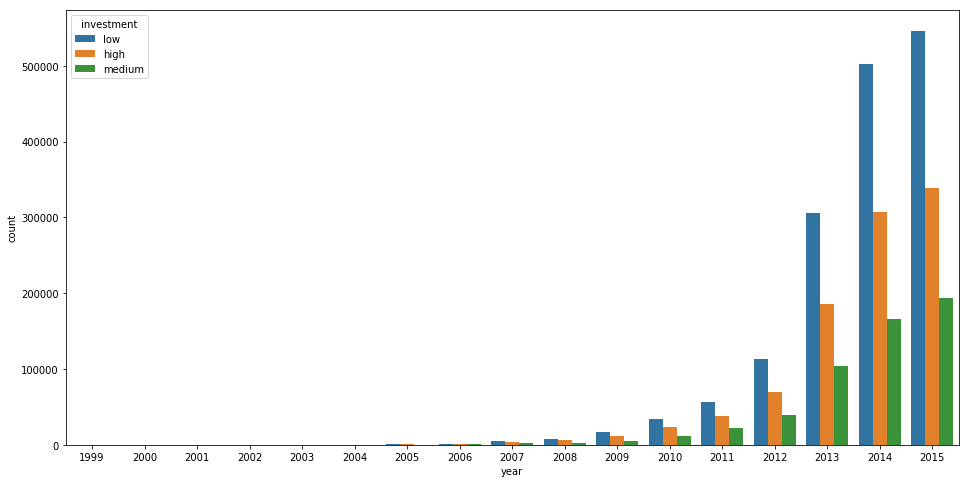

In [131]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.countplot(x="year", hue="investment", data=df, ax=ax)